<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Economic Order Quantity](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/05.01-Economic-Order-Quantity.ipynb) | [Contents](toc.ipynb) | [Vehicle Routing](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/05.03-Vehicle-Routing.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/05.02-Assignment-Problems.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/05.02-Assignment-Problems.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Assignment Problems

This Jupyter notebook demonstrates models for various types of assignment problems using GLPK/MathProg. Run the following cell to perform the necessary installations on Google Colaboratory.

In [1]:
!pip install -q pyomo
!apt-get install glpk-utils -q
!pip install -q cvxpy

Reading package lists...
Building dependency tree...
Reading state information...
glpk-utils is already the newest version (4.65-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


## Example Problem

You work as a logistics manager for a toy manufacturer, and you currently have five delivery trucks on the road. Your trucks are in Austin, Boston, Chicago, Denver, Edmonton, and Fargo. You need them to drive to five other cities: Atlanta, Boise, Charlotte, Dallas, and Fresno. The table below shows the distance in miles between these cities.

| From\To  | Atlanta | Boise    | Charlotte | Dallas | Fresno |
| : -----: | :-----: | :------: | :-------: | :----: | :----: |
| Austin   | 921     | 1627     | 1166      | 196    | 1594   |
| Boston   | 1078    | 2661     | 837       | 1767   | 3107   |
| Chicago  | 716     | 1693     | 756       | 925    | 2140   |
| Denver   | 1400    | 815      | 1561      | 788    | 1142   |
| Edmonton | 3764    | 1718     | 3848      | 3310   | 2835   |

Where should you send each of your trucks in order to minimize travel distance?

### Combinatorial Complexity

How many ways are there to assign destinations to each truck?

$N = 5 \times 4 \times 3 \times 2 \times 1 = 120$

In general there are 

$N = n!$ 

ways to assign $n$ resources to $n$ tasks.

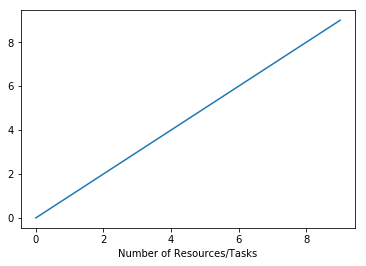

In [2]:
%matplotlib inline
import math as math
import matplotlib.pyplot as plt
import numpy as np

n = np.arange(0,10)
plt.plot(n,n);
plt.xlabel('Number of Resources/Tasks');

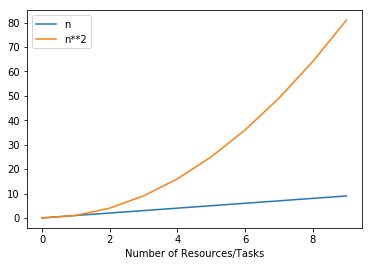

In [3]:
plt.xlabel('Number of Resources/Tasks')
plt.plot(n,n,n,n**2)
plt.legend(['n','n**2'],loc='best');

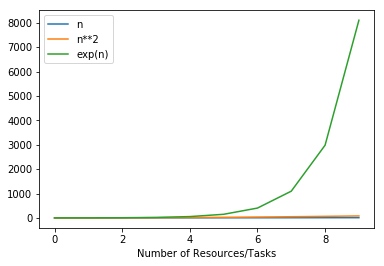

In [4]:
plt.xlabel('Number of Resources/Tasks')
plt.plot(n,n,n,n**2,n,np.exp(n))
plt.legend(['n','n**2','exp(n)'],loc='best');

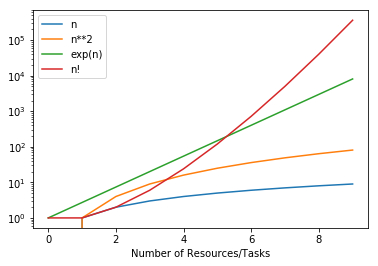

In [5]:
plt.xlabel('Number of Resources/Tasks')
plt.semilogy(n,n,n,n**2,n,np.exp(n),n,[math.factorial(i) for i in n])
plt.legend(['n','n**2','exp(n)','n!'],loc='best');

### Types of Complexity

$$ Combinatoric >> Exponential >> Geometric >> Linear $$

Depending on the details, assignment problems can range from simple to very difficult to solve. The difficulty will depend on the exact details of the problem, the availability of specialized algorithms for a specific problem, and what features can be left out without compromising the utility of the solution.

## Formulation of a Basic Assignment Problem

Let _x[R,T]_ be a binary variable where _x[R,T] = 1_ means resource _R_ is assigned to task _T_. 

One resource must be assigned to each task. So for all $t\in TASKS$

$$\sum_{r \in RESOURCES} x[R,T] = 1$$  

Each resource must be assigned to one task. So for all $r\in RESOURCES$

$$\sum_{t \in TASKS} x[R,T] = 1$$  

In [6]:
%%writefile Assign.mod

set RESOURCES;
set TASKS;

param a {RESOURCES,TASKS} >= 0;

var x {RESOURCES,TASKS} binary;

minimize Cost: sum{r in RESOURCES, t in TASKS} a[r,t]*x[r,t];
subject to R {r in RESOURCES}: sum {t in TASKS} x[r,t] = 1;
subject to T {t in TASKS}: sum {r in RESOURCES} x[r,t] = 1;

solve;

printf "\n\n";
for {r in RESOURCES} {
   for {t in TASKS : x[r,t] == 1} {
      printf "Assign %10s   to %10s   Cost: %6.0f\n", r, t, a[r,t];
   }
}
printf "\n\n";

end;


Overwriting Assign.mod


## Solution

In [7]:
%%script glpsol -m Assign.mod -d /dev/stdin

set RESOURCES := Austin Boston Chicago Denver Edmonton ;
set TASKS := Atlanta Boise Charlotte Dallas Fresno ;
    
param a :   Atlanta	 Boise Charlotte Dallas Fresno :=
Austin       921     1627    1166      196   1594
Boston      1078     2661     837     1767   3107
Chicago      716     1693     756      925   2140
Denver      1400      815    1561      788   1142
Edmonton    3764     1718    3848     3310   2835 ;

end;

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m Assign.mod -d /dev/stdin
Reading model section from Assign.mod...
Assign.mod:23: warning: final NL missing before end of file
23 lines were read
Reading data section from /dev/stdin...
12 lines were read
Generating Cost...
Generating R...
Generating T...
Model has been successfully generated
GLPK Integer Optimizer, v4.65
11 rows, 25 columns, 75 non-zeros
25 integer variables, all of which are binary
Preprocessing...
10 rows, 25 columns, 50 non-zeros
25 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 9
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
10 rows, 25 columns, 50 non-zeros
      0: obj =   1.211800000e+04 inf =   3.000e+00 (1)
      7: obj =   8.790000000e+03 inf =   0.000e+00 (0)
*    16: obj =   4.609000000e+03 inf =   0.0

## Solution using CVXPY

In [8]:
import pandas as pd

LOCATIONS = ['Austin','Boston','Chicago','Denver','Edmonton']

distances = pd.DataFrame(index=LOCATIONS)
distances['Atlanta'] = [921,1078,716,1400,3764]
distances['Boise'] = [1627, 2661, 1693, 815, 1718]
distances['Charlotte'] = [1166, 837, 756, 1561, 3848]
distances['Dallas'] = [196, 1767, 925, 788, 3310]
distances['Fresno'] = [1594, 3107, 2140, 1142, 2835]

distances

,Atlanta,Boise,Charlotte,Dallas,Fresno
Austin,921,1627,1166,196,1594
Boston,1078,2661,837,1767,3107
Chicago,716,1693,756,925,2140
Denver,1400,815,1561,788,1142
Edmonton,3764,1718,3848,3310,2835


In [9]:
import cvxpy as cvx
import numpy as np

RESOURCES = distances.index
TASKS = distances.columns

x = {r:{t:cvx.Variable(boolean=True) for t in TASKS} for r in RESOURCES}

R = [sum([x[r][t] for t in TASKS]) == 1 for r in RESOURCES]
T = [sum([x[r][t] for r in RESOURCES]) == 1 for t in TASKS]
constraints = R + T

cost = sum([distances.loc[r][t]*x[r][t] for t in TASKS for r in RESOURCES])
prob = cvx.Problem(cvx.Minimize(cost), constraints)

prob.solve()

print(prob.status)

for r in RESOURCES:
    for t in TASKS:
        if int(np.round(x[r][t].value)):
            print("Assign {0:10s} to {1:10s} Cost: {2:5.0f}".format(r,t,distances.loc[r,t]))
    

optimal
Assign Austin     to Dallas     Cost:   196
Assign Boston     to Charlotte  Cost:   837
Assign Chicago    to Atlanta    Cost:   716
Assign Denver     to Fresno     Cost:  1142
Assign Edmonton   to Boise      Cost:  1718


## Example

A foreman has ﬁve workers and ﬁve jobs to complete. The
time in hours each worker needs to complete each job is shown in the following
table.

| Resource\Task | Job 1 | Job 2 | Job 3 | Job 4 | Job 5 |
| :-----------: | :---: | :---: | :---: | :---: | :---: |
| Worker 1      | 3     | 4     | 8     | 7     | 8     |
| Worker 2      | 2     | 5     | 3     | 2     | 6     |
| Worker 3      | 7     | 9     | 1     | 8     | 3     |
| Worker 4      | 5     | 3     | 4     | 6     | 6     |
| Worker 5      | 8     | 9     | 7     | 5     | 8     |

### What is the minimum time solution if one worker is assigned to each job?

In [10]:
%%script glpsol -m Assign.mod -d /dev/stdin

set RESOURCES := Worker_1 Worker_2 Worker_3 Worker_4 Worker_5 ;
set TASKS := Job_1 Job_2 Job_3 Job_4 Job_5 ;
    
param a : Job_1	Job_2 Job_3	Job_4 Job_5 :=
Worker_1	3	4	8	7	8
Worker_2	2	5	3	2	6
Worker_3	7	9	1	8	3
Worker_4	5	3	4	6	6
Worker_5	8	9	7	5	8 ;

end;

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m Assign.mod -d /dev/stdin
Reading model section from Assign.mod...
Assign.mod:23: warning: final NL missing before end of file
23 lines were read
Reading data section from /dev/stdin...
12 lines were read
Generating Cost...
Generating R...
Generating T...
Model has been successfully generated
GLPK Integer Optimizer, v4.65
11 rows, 25 columns, 75 non-zeros
25 integer variables, all of which are binary
Preprocessing...
10 rows, 25 columns, 50 non-zeros
25 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 9
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
10 rows, 25 columns, 50 non-zeros
      0: obj =   2.800000000e+01 inf =   3.000e+00 (1)
      7: obj =   2.000000000e+01 inf =   0.000e+00 (0)
*    12: obj =   1.700000000e+01 inf =   0.0

### What is the minimum time solution if workers can be assigned multiple times?

In [11]:
%%script glpsol -m /dev/stdin

set RESOURCES;
set TASKS;

param a {RESOURCES,TASKS} >= 0;

var x {RESOURCES,TASKS} binary;

maximize Cost: sum{r in RESOURCES, t in TASKS} a[r,t]*x[r,t];
#subject to R {r in RESOURCES}: sum {t in TASKS} x[r,t] = 1;
subject to T {t in TASKS}: sum {r in RESOURCES} x[r,t] = 1;

solve;

printf "\n\n";
for {r in RESOURCES} {
   for {t in TASKS : x[r,t] == 1} {
      printf "Assign %10s   to %10s   Cost: %6.0f\n", r, t, a[r,t];
   }
}
printf "\n\n";

data;

set RESOURCES := Worker_1 Worker_2 Worker_3 Worker_4 Worker_5 ;
set TASKS := Job_1 Job_2 Job_3 Job_4 Job_5 ;
    
param a : Job_1	Job_2 Job_3	Job_4 Job_5 :=
Worker_1	3	4	8	7	8
Worker_2	2	5	3	2	6
Worker_3	7	9	1	8	3
Worker_4	5	3	4	6	6
Worker_5	8	9	7	5	8 ;

end;

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m /dev/stdin
Reading model section from /dev/stdin...
Reading data section from /dev/stdin...
35 lines were read
Generating Cost...
Generating T...
Model has been successfully generated
GLPK Integer Optimizer, v4.65
6 rows, 25 columns, 50 non-zeros
25 integer variables, all of which are binary
Preprocessing...
5 rows, 25 columns, 25 non-zeros
25 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 5
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
5 rows, 25 columns, 25 non-zeros
*     0: obj =   3.700000000e+01 inf =   0.000e+00 (4)
*     3: obj =   4.100000000e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+     3: mip =     not found yet <=              +inf        (1

### Exercise

Suppose we want to assign just two workers. What is the minimum time solution using just two workers?

## Knapsack Problems

### Typical Applications

* Resource allocations with financial constraints
* Construction and scoring of a heterogenous test
* Selection of Capital Investments

### Example

Need to complete a set of jobs


|       | A | B | C | D  | E  | F | G |
|:-----:|:-:|:-:|:-:|:--:|:--:|:-:|:-:|
| Value | 7 | 9 | 5 | 12 | 14 | 6 | 12 |
| Time  | 3 | 4 | 2 | 6  | 7  | 3 | 5 |



In [12]:
%%script glpsol -m /dev/stdin

set ITEMS;

param value{ITEMS};
param cost{ITEMS};

var x {ITEMS} binary;

maximize Obj: sum{i in ITEMS} value[i]*x[i];
subject to C: sum{i in ITEMS} cost[i]*x[i] <= 12 ;

solve;

for {i in ITEMS}{
    printf "%3s  %2d\n",i,x[i];
}

data;

param : ITEMS : value cost :=
 A   7 3
 B   9 4
 C   5 2
 D  12 6
 E  14 7
 F   6 3
 G  12 5 ;
            
end;


GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m /dev/stdin
Reading model section from /dev/stdin...
Reading data section from /dev/stdin...
29 lines were read
Generating Obj...
Generating C...
Model has been successfully generated
GLPK Integer Optimizer, v4.65
2 rows, 7 columns, 14 non-zeros
7 integer variables, all of which are binary
Preprocessing...
1 row, 7 columns, 7 non-zeros
7 integer variables, all of which are binary
Scaling...
 A: min|aij| =  2.000e+00  max|aij| =  7.000e+00  ratio =  3.500e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 1
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
1 row, 7 columns, 7 non-zeros
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (7)
*     7: obj =   2.850000000e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+     7: mip =     not found yet <=              +inf        (1; 0)
Solut

### Exercise

| Investment | Location | Cost (millions) | Expected Profit |
| :--------: | :------: | :-------------: | :-------------: |
| 1 | Europe   | 10 | 1.0 |
| 2 | Europe | 8 | 0.9 |
| 3 | Europe | 8 | 0.9 |
| 4 | South America | 16 | 2.0 |
| 5 | South America | 12 | 1.4 |
| 6 | Africa | 4 | 0.2 |
| 7 | Africa | 6 | 0.5 |
| 8 | Africa | 16 | 2.1 |

The objective is to maximize the total expected profits subject to:

* Contractual commitments require at least 2 investments in Europe
* There must be one South American Investment
* No more than one African investment
* Total cost must be less than $40 million





<!--NAVIGATION-->
< [Economic Order Quantity](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/05.01-Economic-Order-Quantity.ipynb) | [Contents](toc.ipynb) | [Vehicle Routing](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/05.03-Vehicle-Routing.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/05.02-Assignment-Problems.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/05.02-Assignment-Problems.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>